<a href="https://colab.research.google.com/github/vanigupta123/nbody_sim/blob/main/nbody_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
%%writefile main.cu
#include <stdio.h>
#include <curand_kernel.h>
#include <cuda_runtime.h>
#include <math.h>
#include <fstream>

__global__ void initParticles(int N, float4 *pos, float4 *vel, float4 *acc) {
  // this is a kernel and will be called with params<<<grid_dimensions, block_dimensions>>>
  int idx = (blockIdx.x * blockDim.x) + threadIdx.x;
  // printf("%d\n", idx);
  if (idx >= N) return;

  curandState state;
  curand_init(1234ULL, idx, 0, &state);

  float4 p;
  p.x = curand_uniform(&state);
  p.y = curand_uniform(&state);
  p.z = curand_uniform(&state);
  p.w = 1.0 + curand_uniform(&state);
  pos[idx] = p;
  vel[idx] = {0.0f, 0.0f, 0.0f, 0.0f};
  acc[idx] = {0.0f, 0.0f, 0.0f, 0.0f};
}

__device__ float3 getAcceleration(float4 &pos_i, float4 &pos_j, float3 &acc) {
  const float EPS2 = 1.0f/150.0f;
  // F = Gm1m2/|r|^2 * r/|r|
  // a1 = Gm2r/|r|^3
  // with softening -> a1 = Gm2r/(|r|^2 + eps^2)^(3/2)
  float3 r;
  float magSquared, val;
  // all threads in a block have access to the same shared memory
  // one shared memory per block
  // must synchronize threads to prevent race condition
    // thread can only continue execution once all threads in block have synchronized
    // must have synchronization at same point for each thread or else the code will deadlock
  r.x = pos_j.x - pos_i.x;
  r.y = pos_j.y - pos_i.y;
  r.z = pos_j.z - pos_i.z;
  magSquared = (r.x*r.x) + (r.y*r.y) + (r.z*r.z) + EPS2;
  val = pos_j.w * rsqrt(magSquared * magSquared * magSquared);
  acc.x += r.x * val;
  acc.y += r.y * val;
  acc.z += r.z * val;
  return acc;
}

__device__ float3 tileCalculation(float4 pos_i, float3 accel, int valid) {
  int i;
  extern __shared__ float4 shPosition[];
  for (i = 0; i < valid; i++) {
    accel = getAcceleration(pos_i, shPosition[i], accel);
  }
  return accel;
}

__global__ void calculateForces(int N, float4 *devA, float4 *devX) {
  extern __shared__ float4 shPosition[]; // var declaration in shared memory
  int gtid = blockIdx.x * blockDim.x + threadIdx.x;
  if (gtid >= N) return;
  float G = 6.6743e-11;
  float3 acc = {0.0f, 0.0f, 0.0f};
  float4 pos_i = devX[gtid];
  // tiles are pxp, where p = blockDim.x
  for (int i = 0, tile = 0; i < N; i += blockDim.x, tile++) {
    int idx = tile * blockDim.x + threadIdx.x;
    if (idx < N) shPosition[threadIdx.x] = devX[idx];
    // guards load for last partial tile. remaining threads otherwise have invalid devX[idx] vals
    __syncthreads();
    int valid = min(blockDim.x, N-tile);
    acc = tileCalculation(pos_i, acc, valid);
    __syncthreads();
  }
  float4 acc4 = {G*acc.x, G*acc.y, G*acc.z, 0.0f}; // for global acceleration var
  devA[gtid] = acc4;
}

__global__ void verletIntegration(int N, float4 *acc, float4 *pos, float4 *vel, float dt) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  if (idx >= N) return;
  float4 a = acc[idx];
  float4 p = pos[idx];
  float4 v = vel[idx];

  // position = x_0 + v dt + (1/2) a dt^2
  p.x += (v.x * dt) + (0.5f * a.x * dt * dt);
  p.y += (v.y * dt) + (0.5f * a.y * dt * dt);
  p.z += (v.z * dt) + (0.5f * a.z * dt * dt);

  // half step of velocity = v_0 + (1/2) a * dt
  v.x += 0.5f * a.x * dt;
  v.y += 0.5f * a.y * dt;
  v.z += 0.5f * a.z * dt;

  pos[idx] = p;
  vel[idx] = v;
}

__global__ void verletIntegration2(int N, float4 *acc, float4 *vel, float dt) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  if (idx >= N) return;

  float4 a = acc[idx];
  float4 v = vel[idx];
  // second half step of velocity after updated acc
  v.x += 0.5f * a.x * dt;
  v.y += 0.5f * a.y * dt;
  v.z += 0.5f * a.z * dt;

  vel[idx] = v;
}

int main() {
  printf("hello from colab GPU!\n");
  int N = 1000;
  float4 *d_pos, *d_vel, *d_acc;
  cudaMalloc(&d_pos, N*sizeof(float4));
  cudaMalloc(&d_vel, N*sizeof(float4));
  cudaMalloc(&d_acc, N*sizeof(float4));

  // one thread per particle
  int blockSize = 256;
  int numBlocks = (N + blockSize - 1)/blockSize; // same as ceil(N/blockSize)
  initParticles<<<numBlocks, blockSize>>>(N, d_pos, d_vel, d_acc);
  int shareMem = sizeof(float4) * blockSize;
  int numSteps = 1000;
  for (int step = 0; step < numSteps; step++) {
    verletIntegration<<<numBlocks, blockSize>>>(N, d_acc, d_pos, d_vel, 0.05f);
    calculateForces<<<numBlocks, blockSize, shareMem>>>(N, d_acc, d_pos);
    verletIntegration2<<<numBlocks, blockSize>>>(N, d_acc, d_vel, 0.05f);

    if (step % 10 == 0) {
      // record position with a particle id
      float4 h_pos[N];
      cudaMemcpy(h_pos, d_pos, N*sizeof(float4), cudaMemcpyDeviceToHost);
      std::ofstream file("output/output_" + std::to_string(step) + ".csv");
      file << "id,x,y,z,m\n";

      for (int i = 0; i < N; i++) {
        file << i << "," << h_pos[i].x << "," << h_pos[i].y << "," << h_pos[i].z << "," << h_pos[i].w << "\n";
      }
      file.close();
    }
  }
  cudaError_t err = cudaGetLastError();
  if (err != cudaSuccess) {
    printf("CUDA error: %s\n", cudaGetErrorString(err));
  }
  cudaDeviceSynchronize();

  // sample of initial velocities and positions
  float4 s_pos[5], s_vel[5], s_acc[5]; // for 5 particles
  cudaMemcpy(s_pos, d_pos, 5*sizeof(float4), cudaMemcpyDeviceToHost);
  cudaMemcpy(s_vel, d_vel, 5*sizeof(float4), cudaMemcpyDeviceToHost);
  cudaMemcpy(s_acc, d_acc, 5*sizeof(float4), cudaMemcpyDeviceToHost);

  for (int i = 0; i < 5; i++) {
    printf("particle with mass %.4f at position (%.2f, %.2f, %.2f) with velocity (%.3e, %.3e, %.3e) and net acc of (%.3e, %.3e, %.3e)\n",
    s_pos[i].w, s_pos[i].x, s_pos[i].y, s_pos[i].z,
    s_vel[i].x, s_vel[i].y, s_vel[i].z,
    s_acc[i].x, s_acc[i].y, s_acc[i].z
    );
  }

  return 0;
}

Overwriting main.cu


In [49]:
!nvcc -arch=sm_75 main.cu -o main

In [50]:
!./main

hello from colab GPU!
particle with mass 1.4552 at position (0.15, 0.43, 0.87) with velocity (6.256e-06, 1.237e-06, -6.626e-06) and net acc of (1.253e-07, 2.477e-08, -1.327e-07)
particle with mass 1.5376 at position (0.82, 0.93, 0.51) with velocity (-5.623e-06, -8.322e-06, -1.867e-07) and net acc of (-1.126e-07, -1.666e-07, -3.739e-09)
particle with mass 1.7425 at position (0.55, 0.81, 0.78) with velocity (-1.115e-06, -6.287e-06, -5.007e-06) and net acc of (-2.233e-08, -1.259e-07, -1.003e-07)
particle with mass 1.5356 at position (0.29, 0.31, 0.62) with velocity (3.721e-06, 4.612e-06, -1.767e-06) and net acc of (7.450e-08, 9.234e-08, -3.537e-08)
particle with mass 1.0584 at position (0.91, 0.56, 0.55) with velocity (-9.665e-06, -1.078e-06, -1.051e-06) and net acc of (-1.935e-07, -2.158e-08, -2.105e-08)


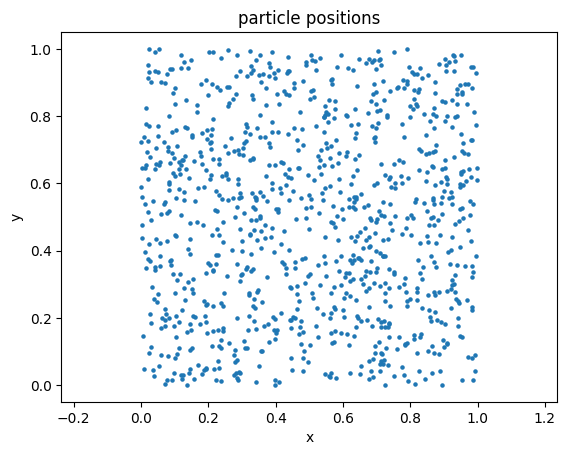

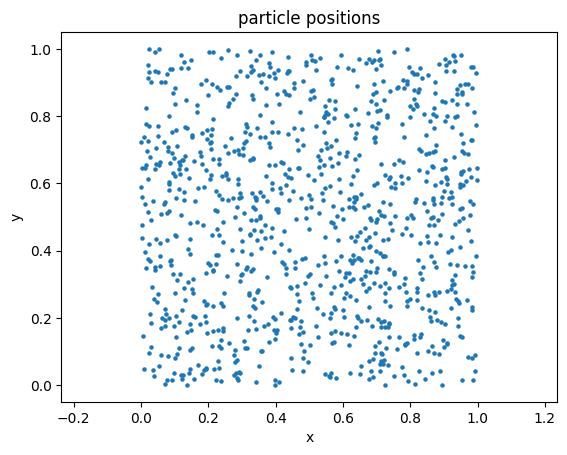

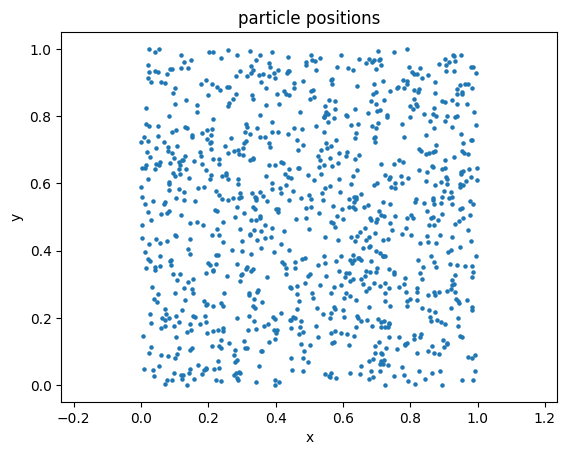

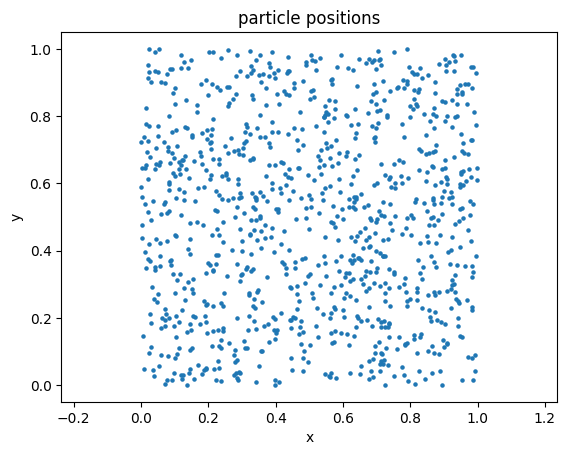

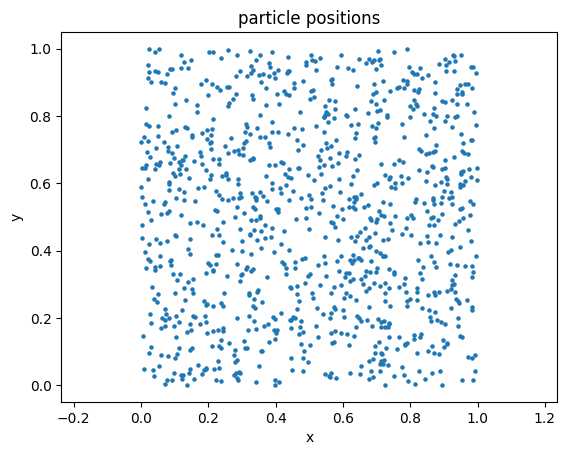

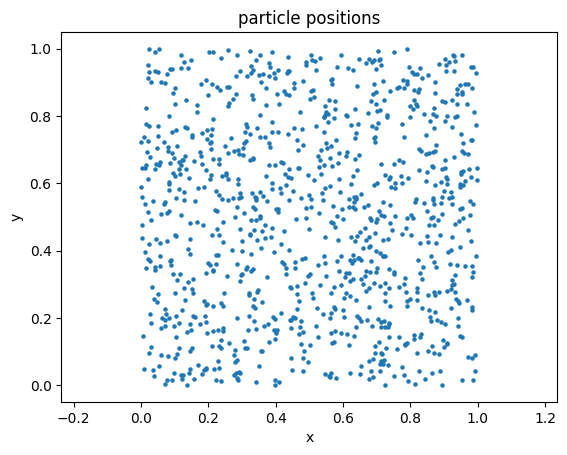

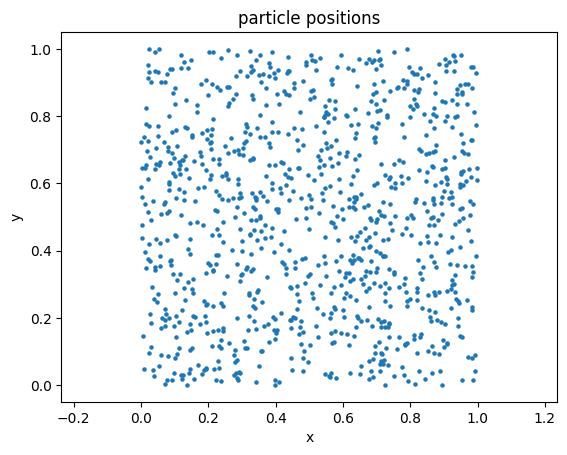

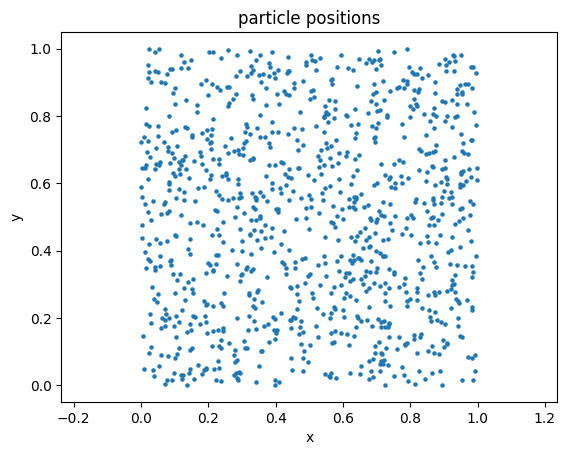

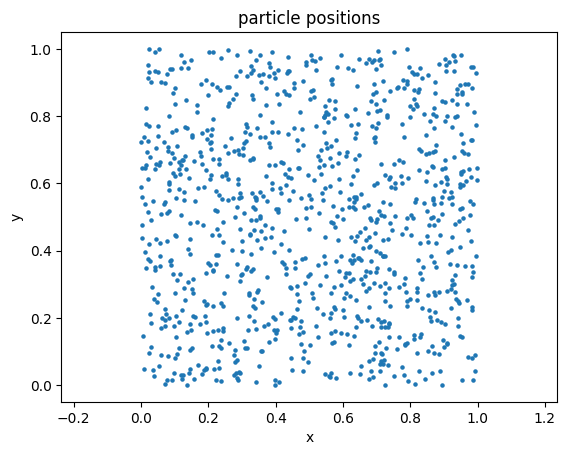

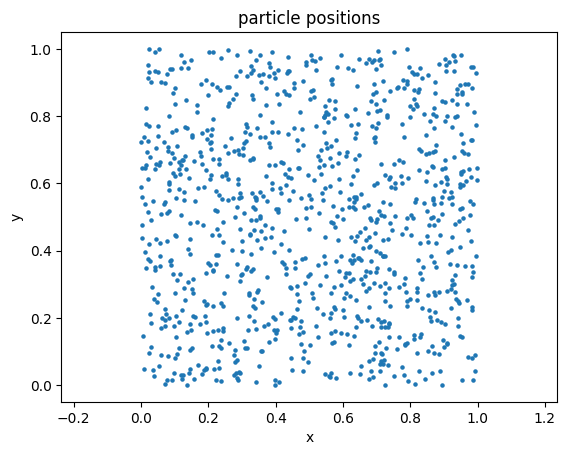

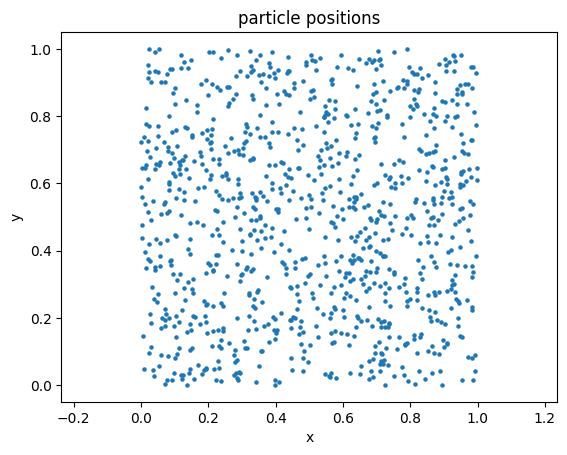

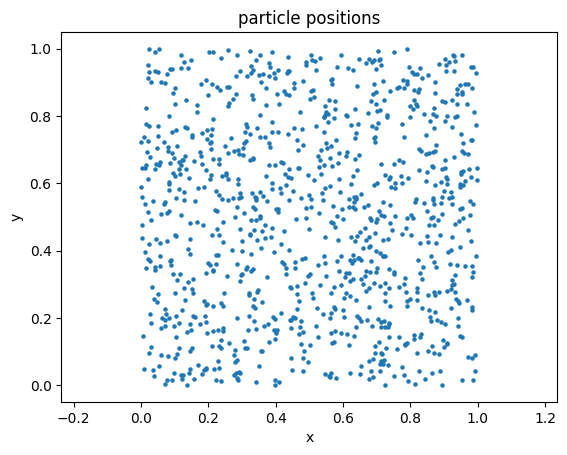

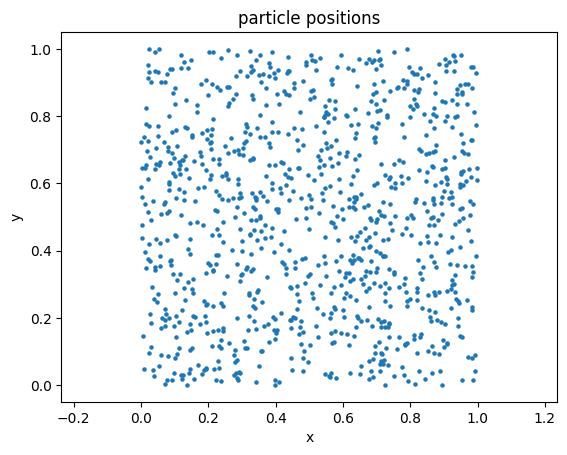

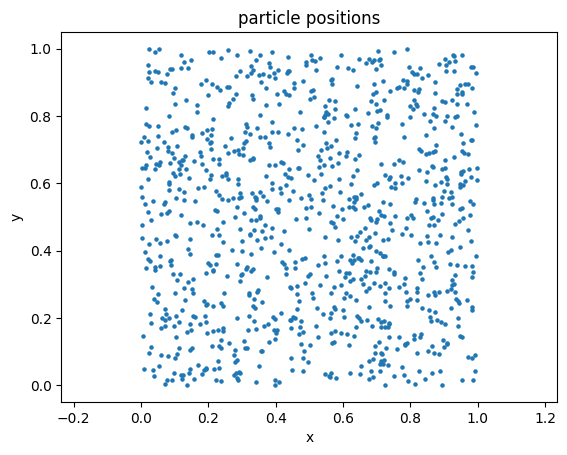

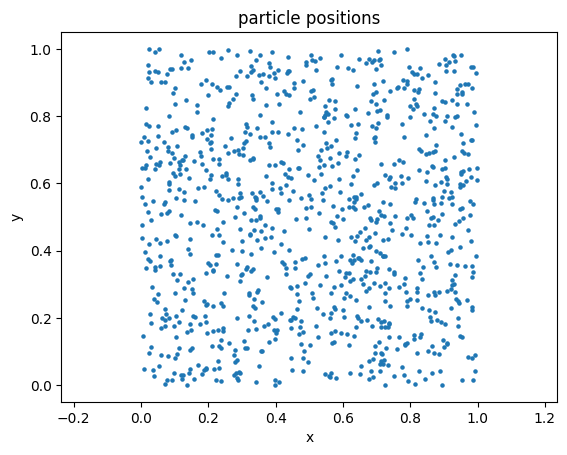

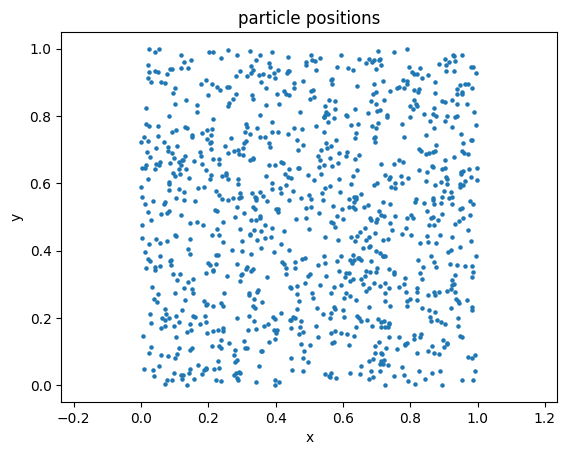

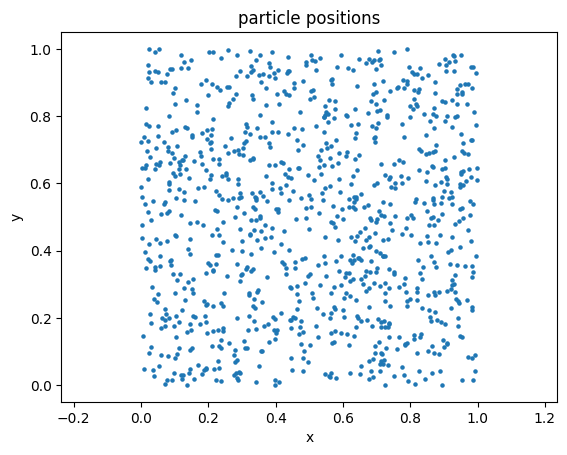

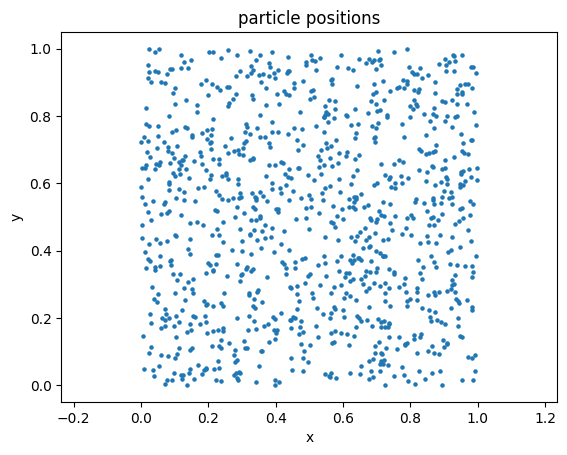

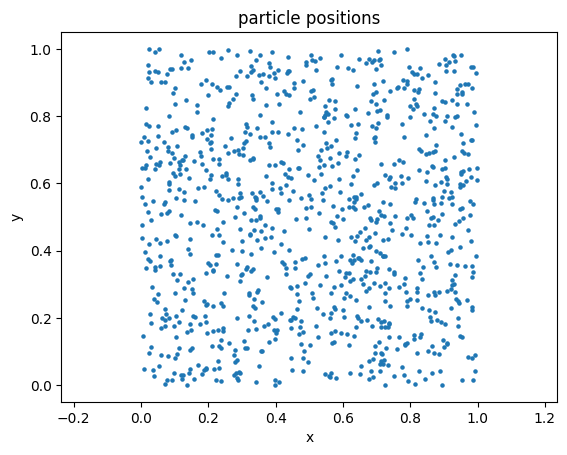

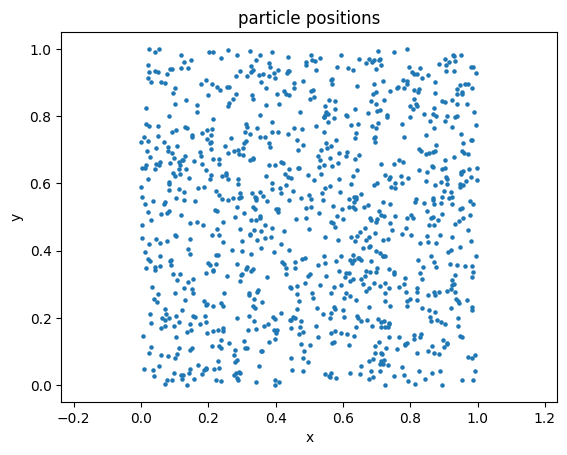

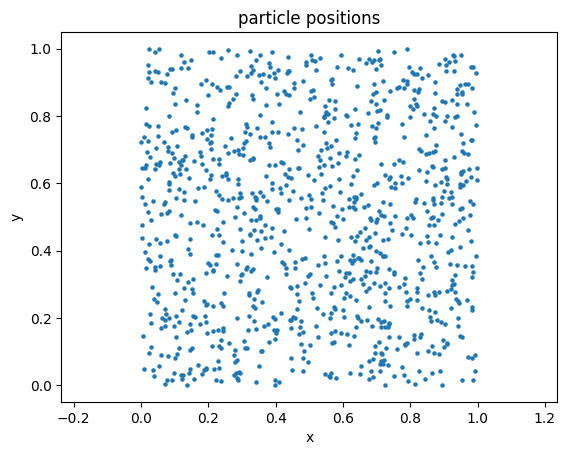

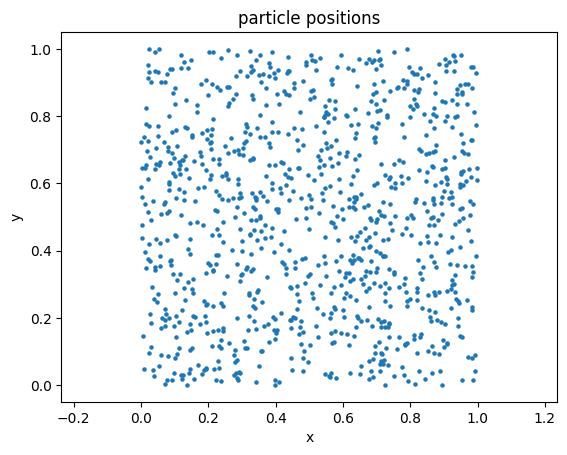

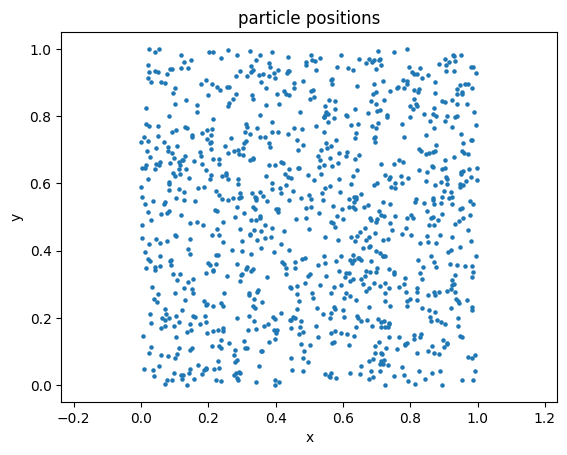

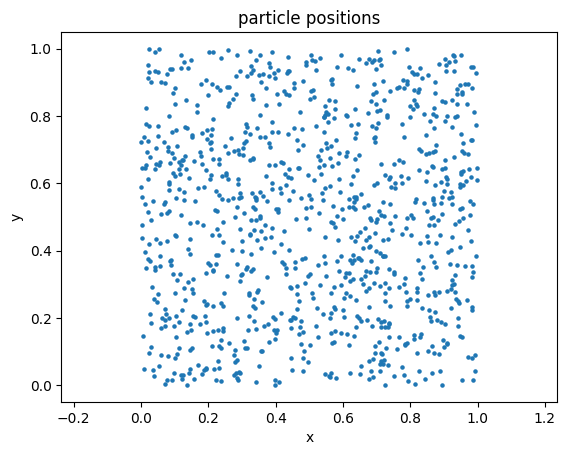

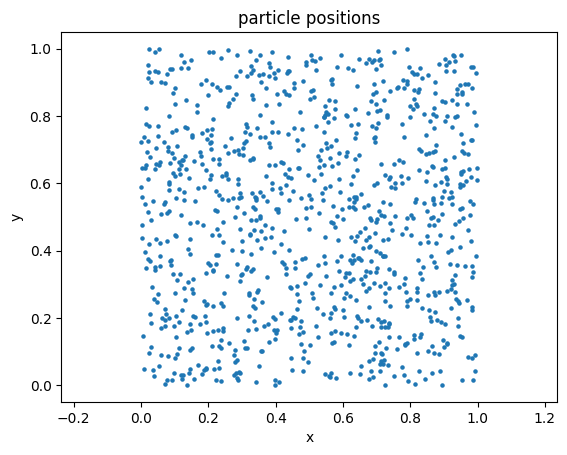

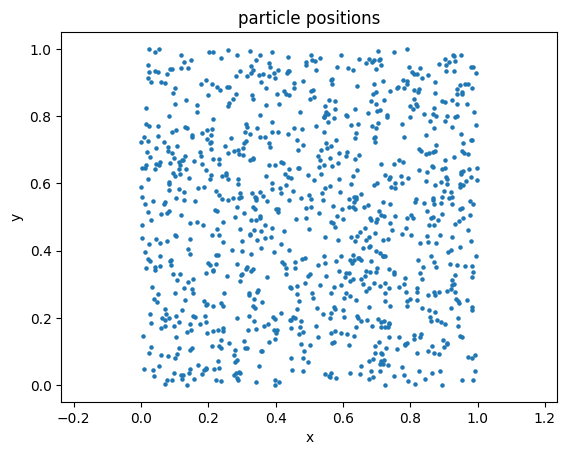

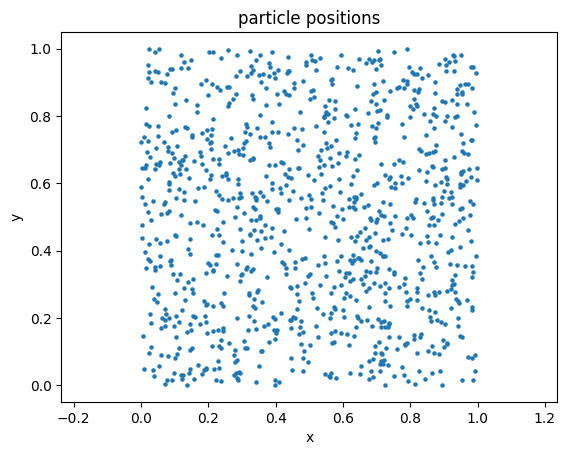

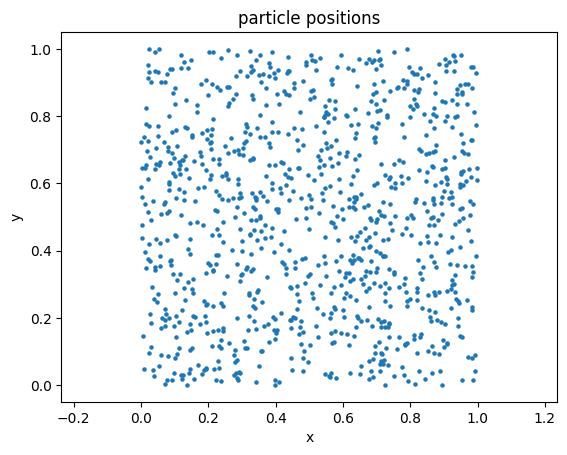

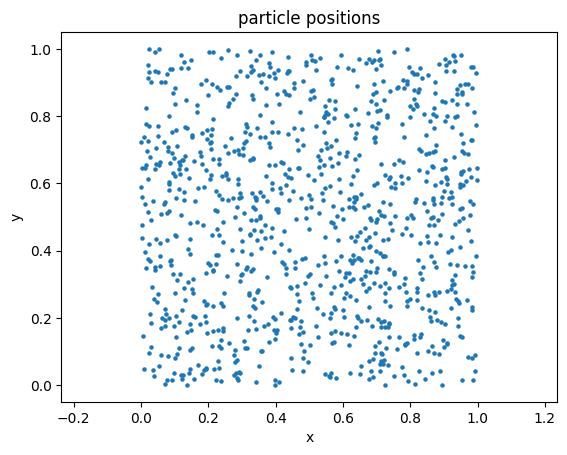

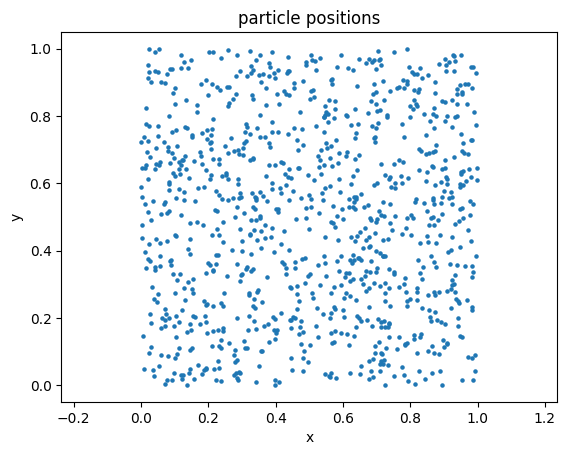

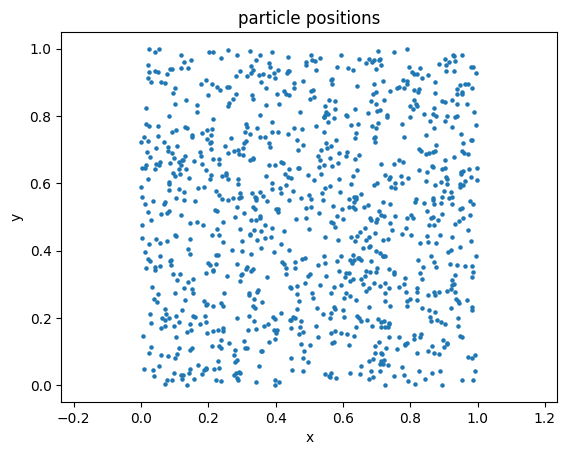

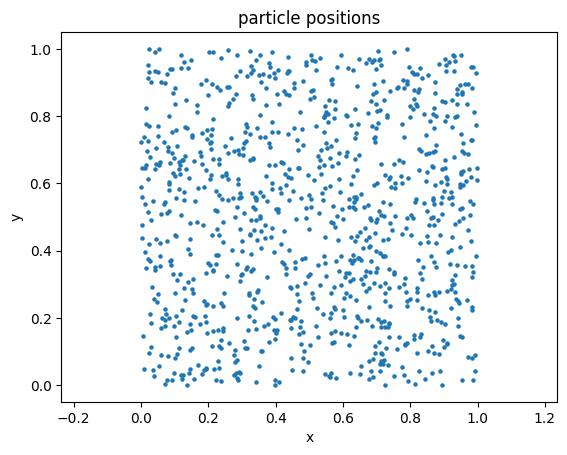

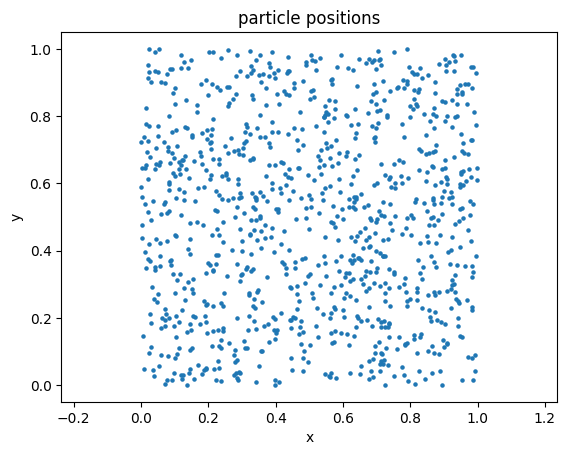

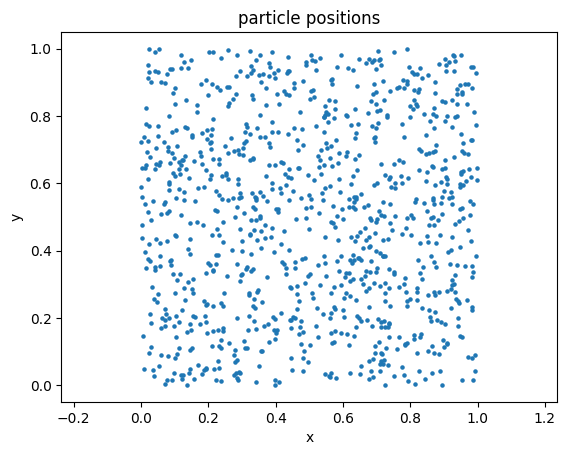

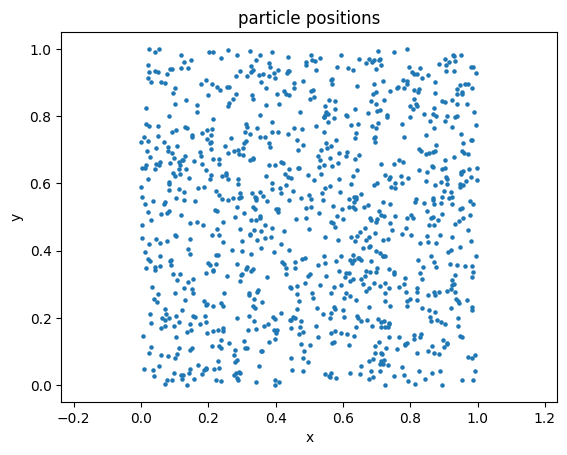

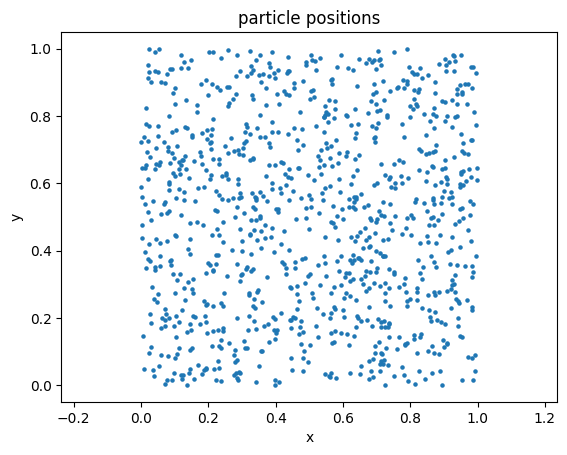

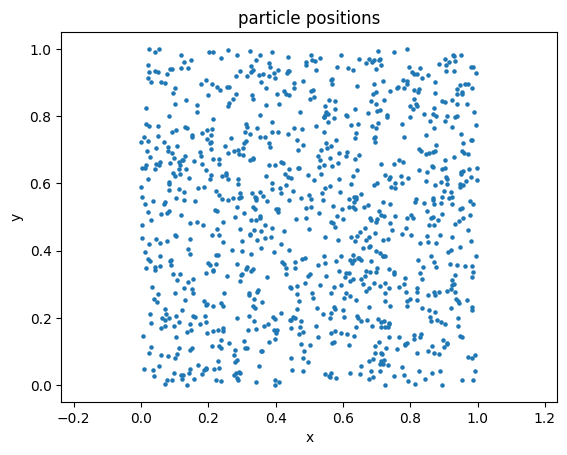

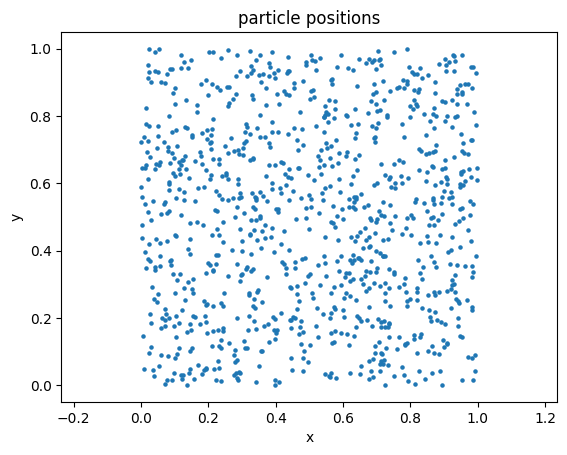

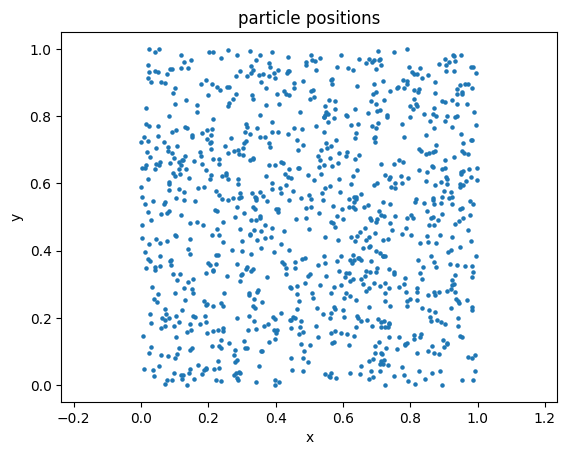

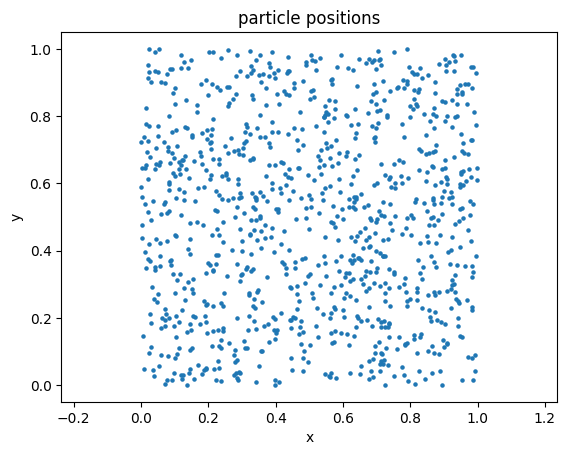

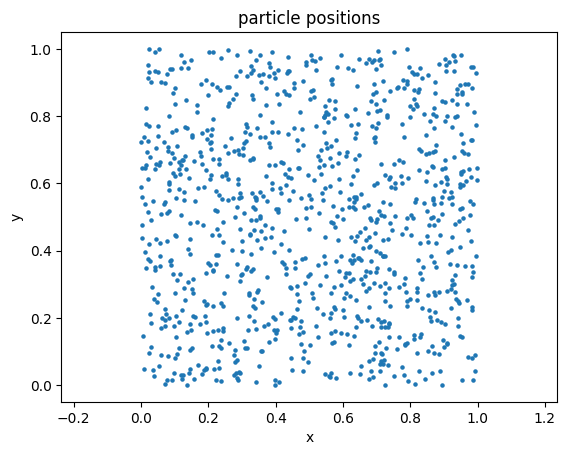

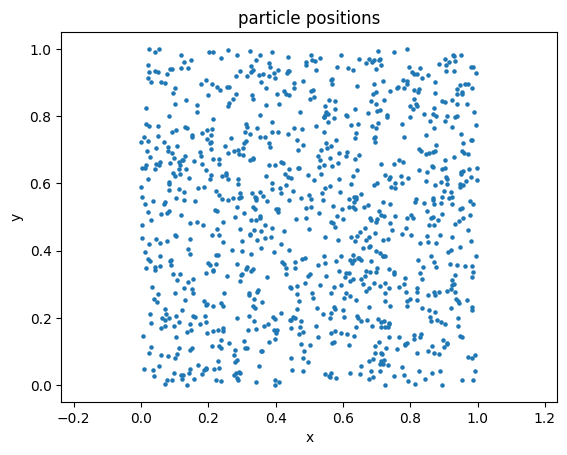

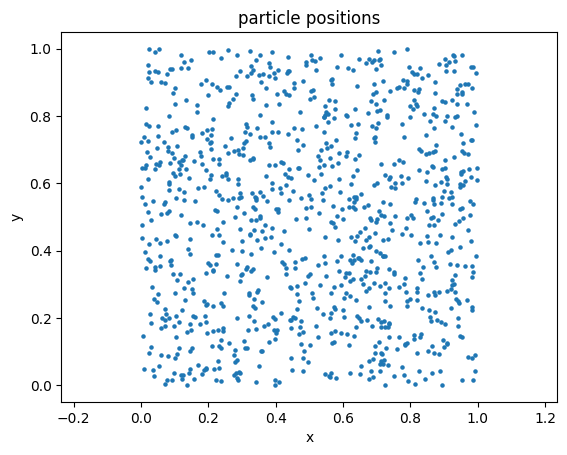

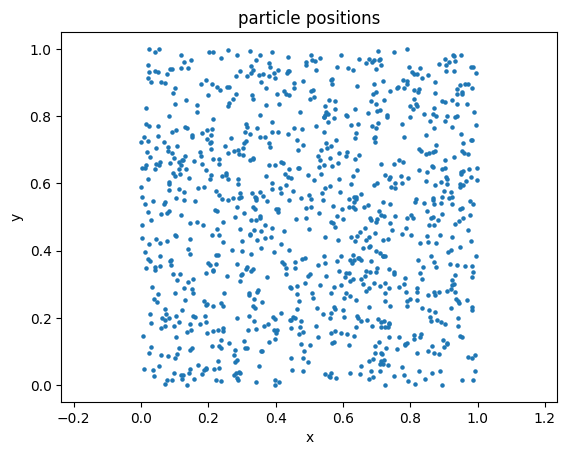

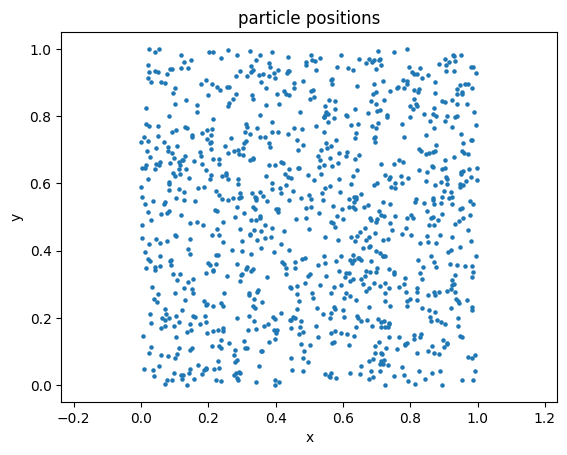

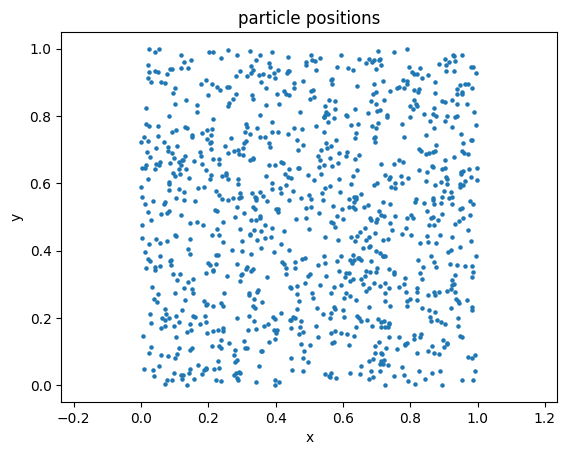

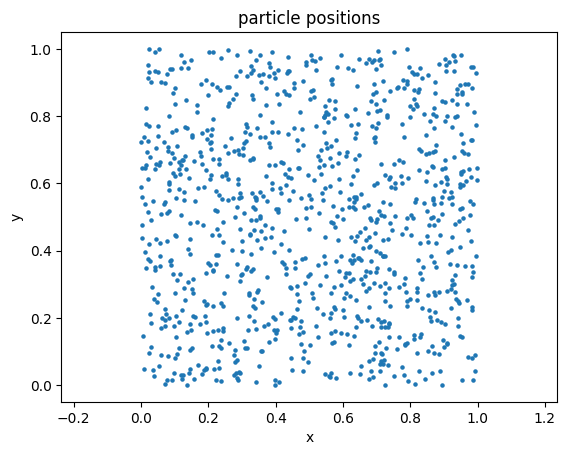

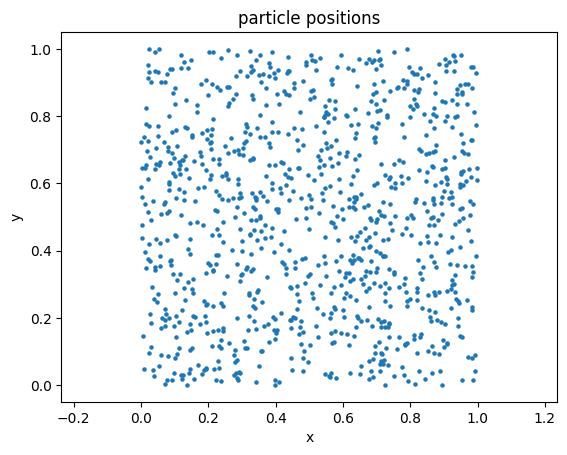

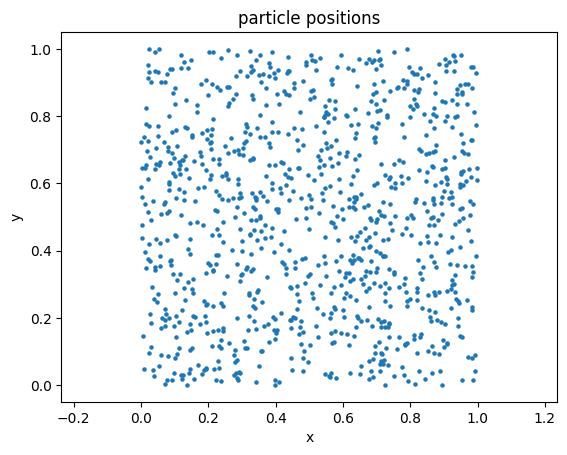

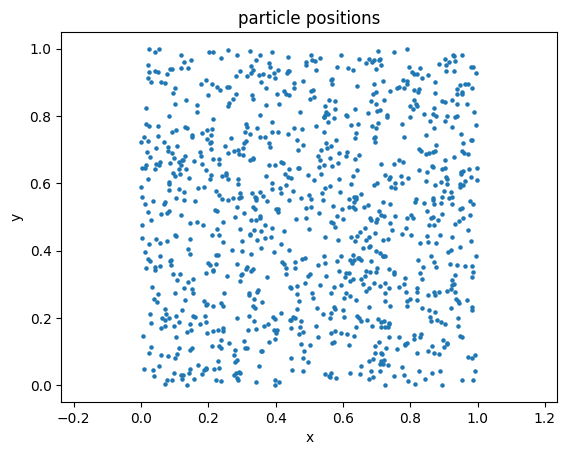

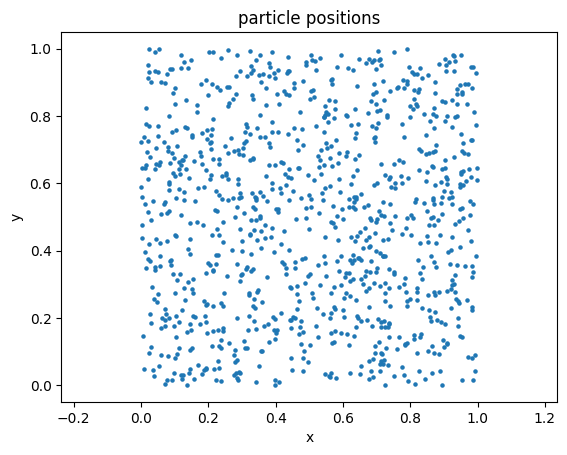

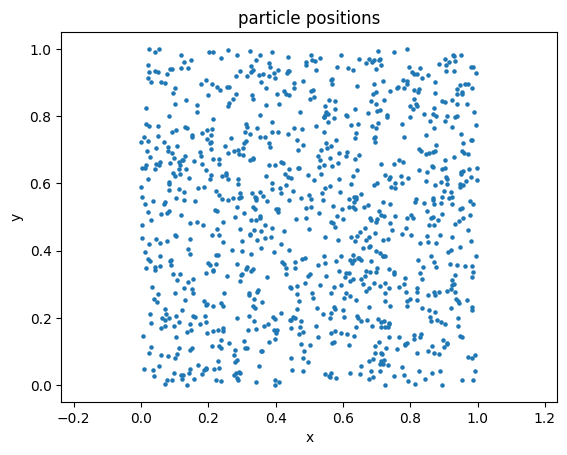

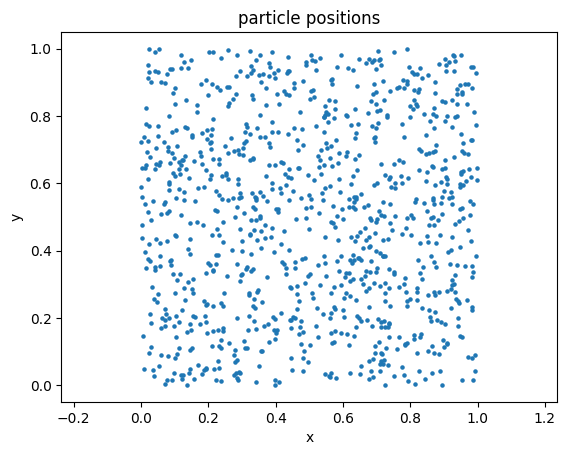

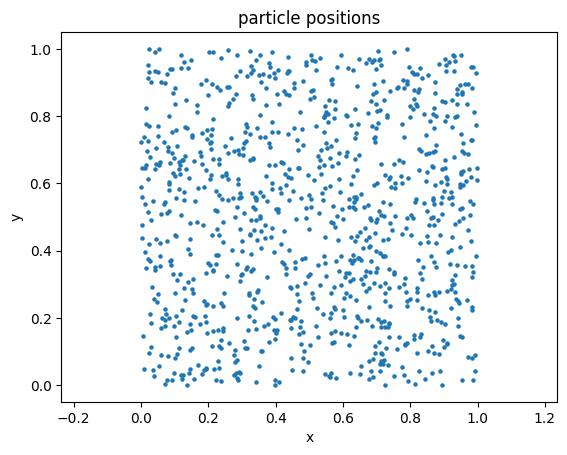

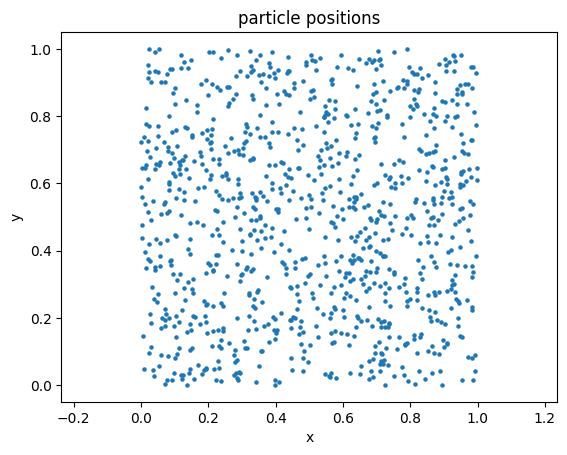

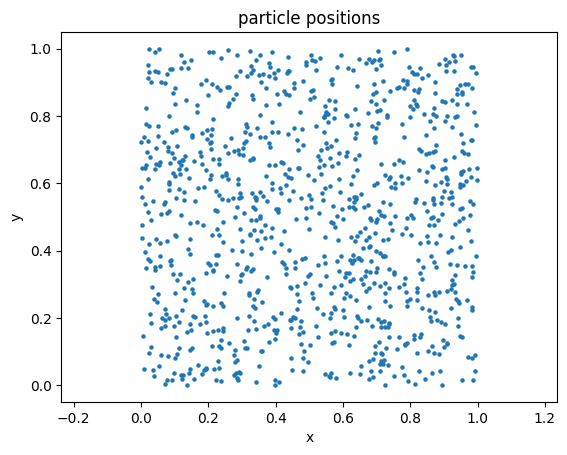

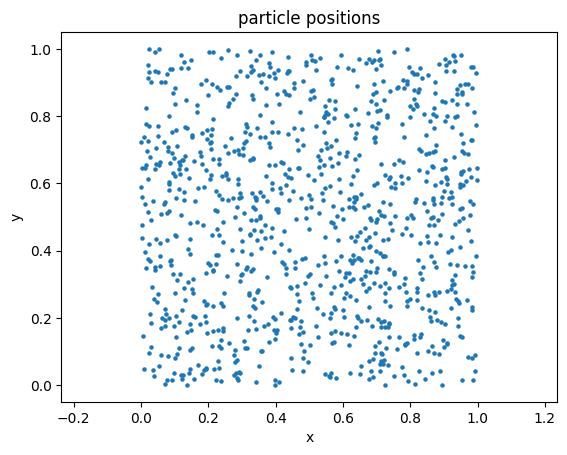

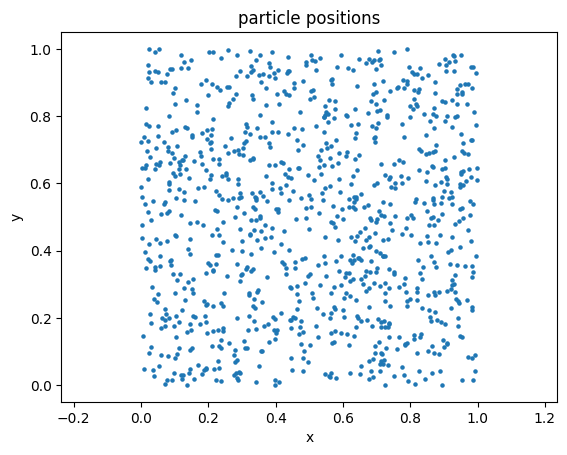

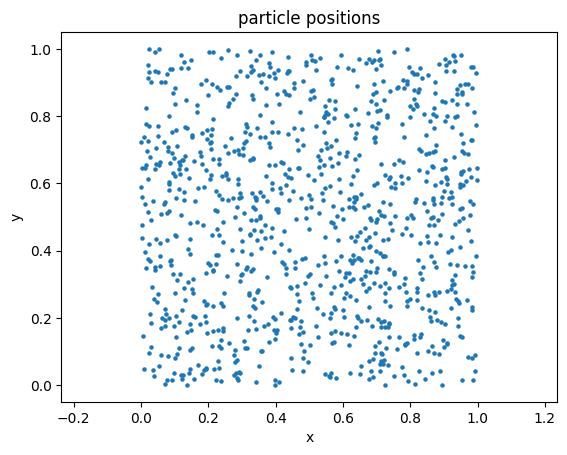

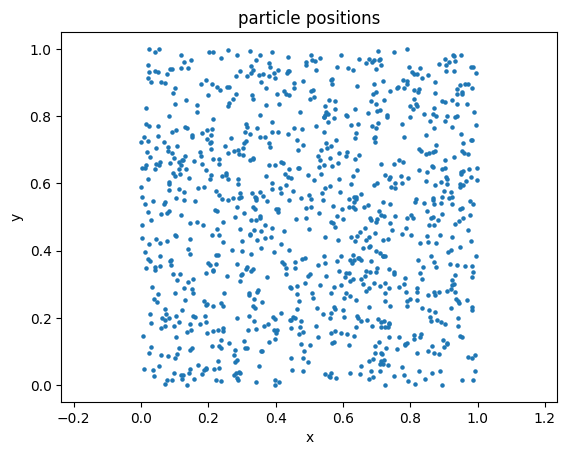

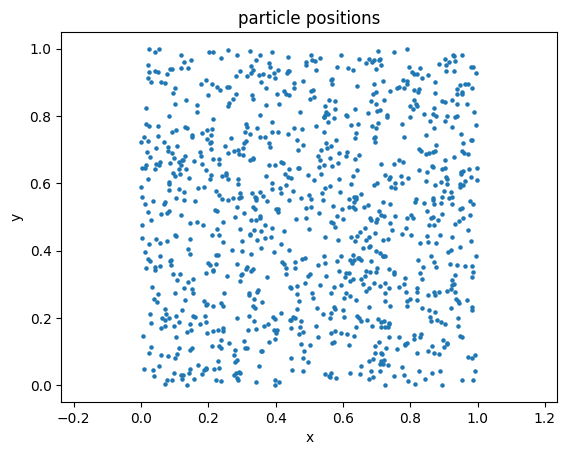

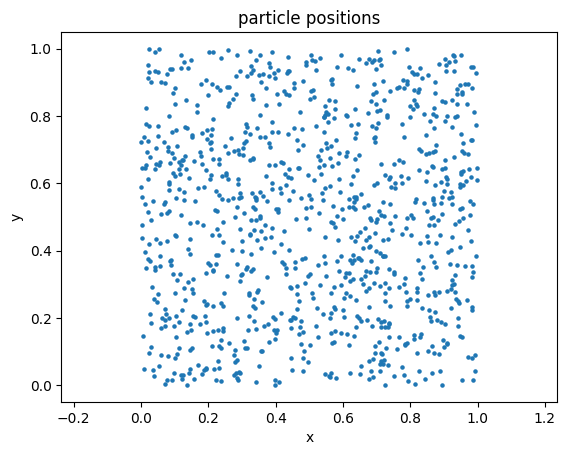

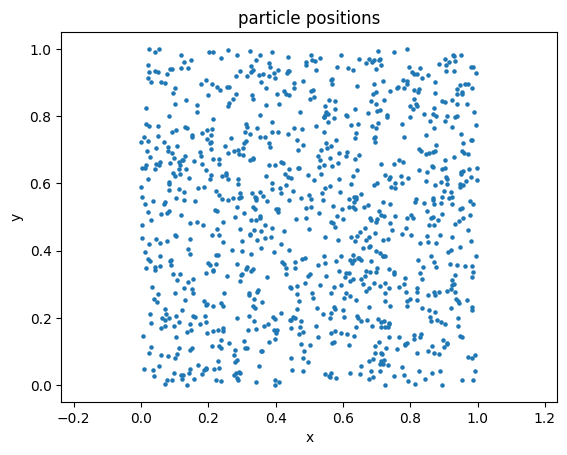

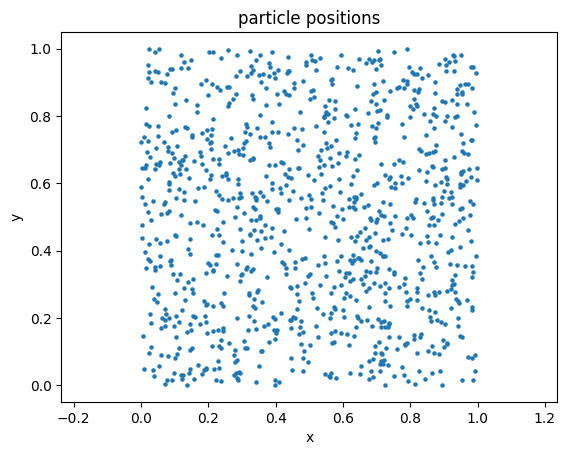

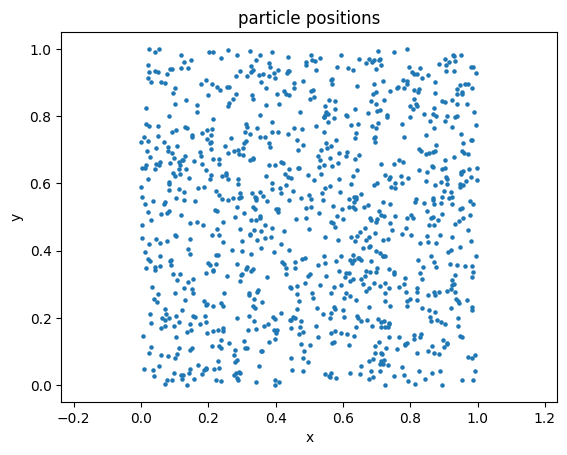

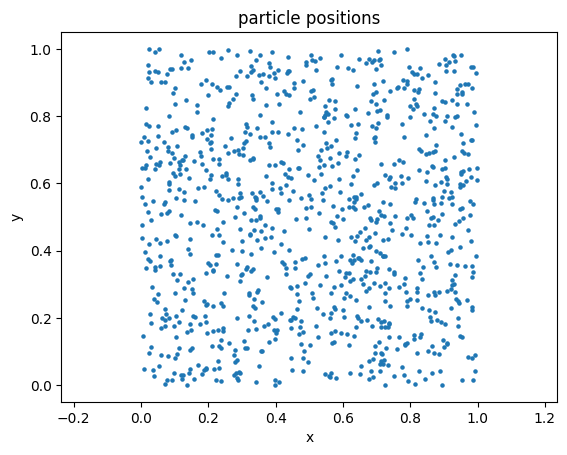

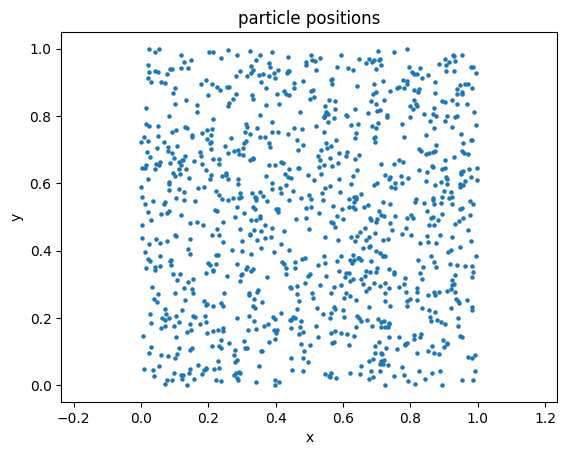

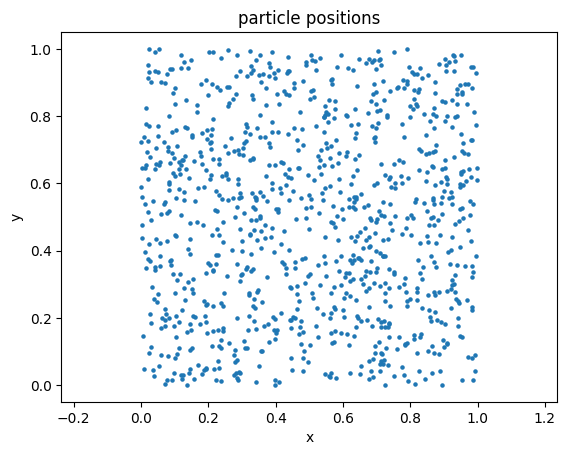

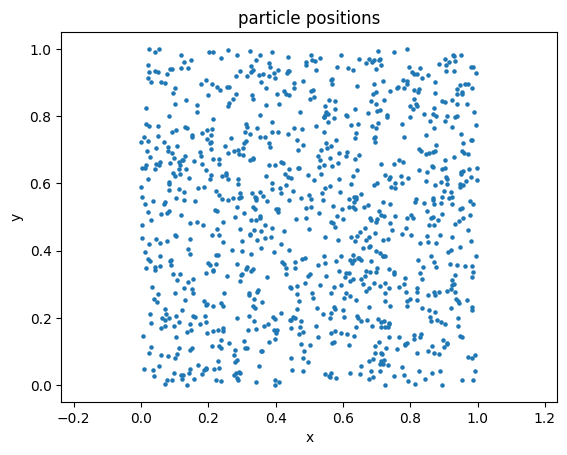

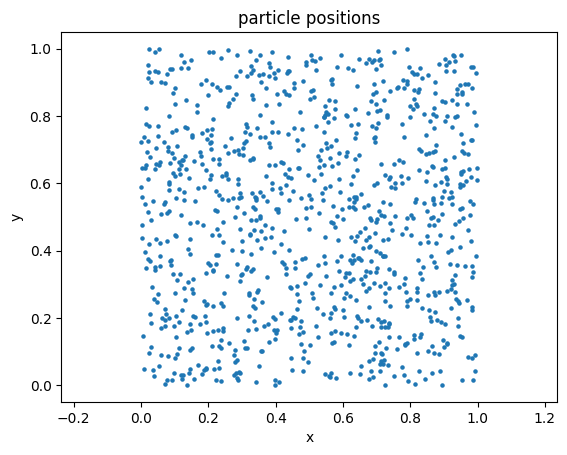

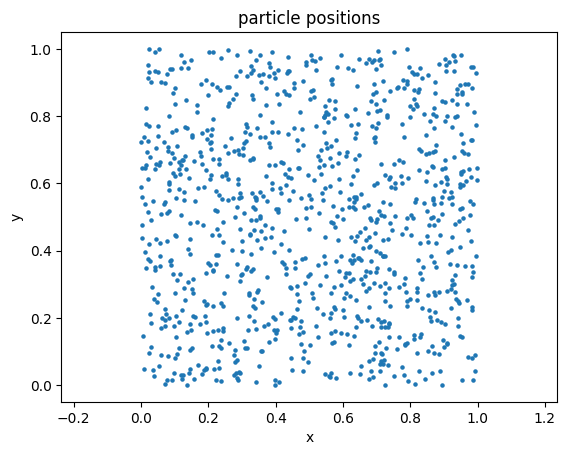

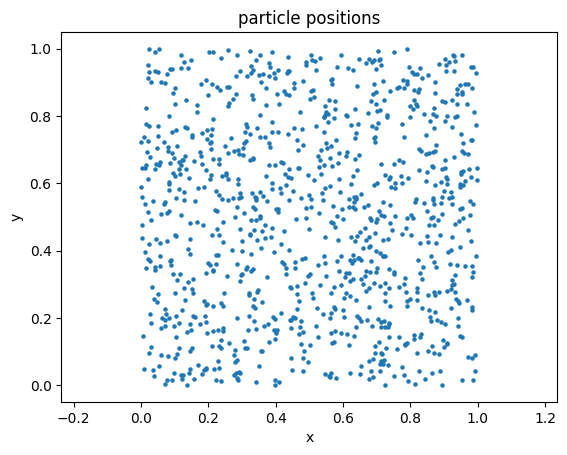

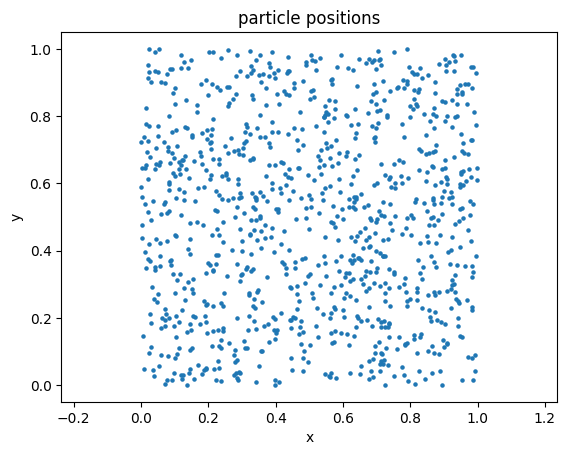

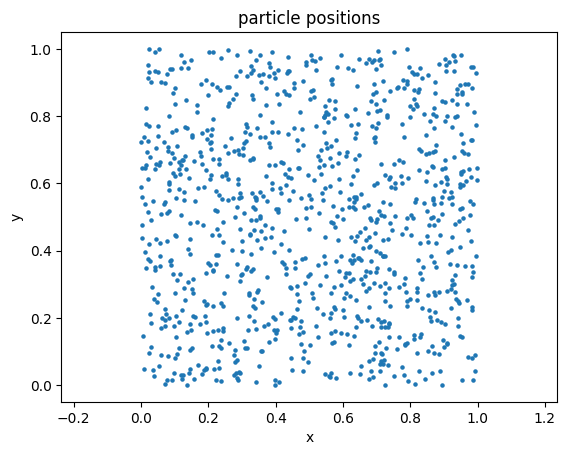

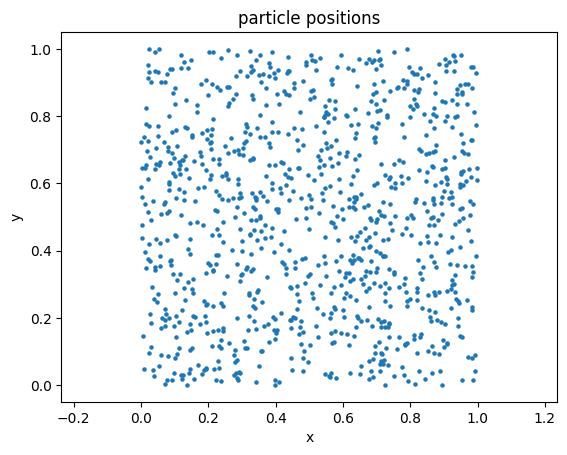

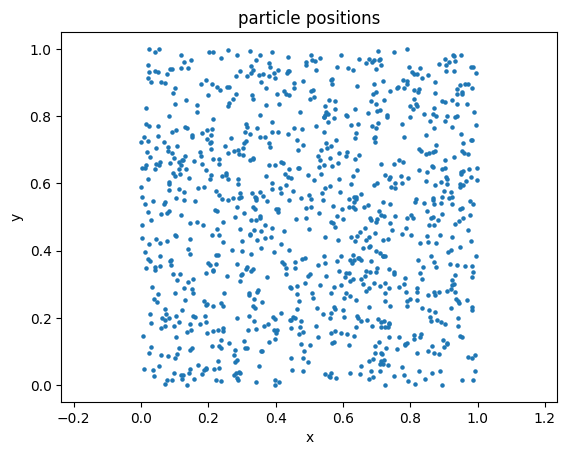

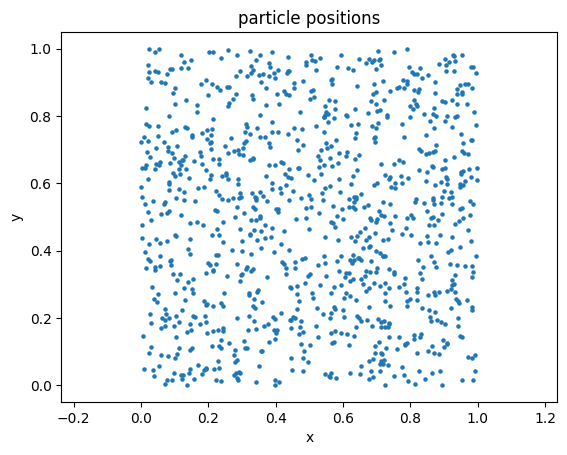

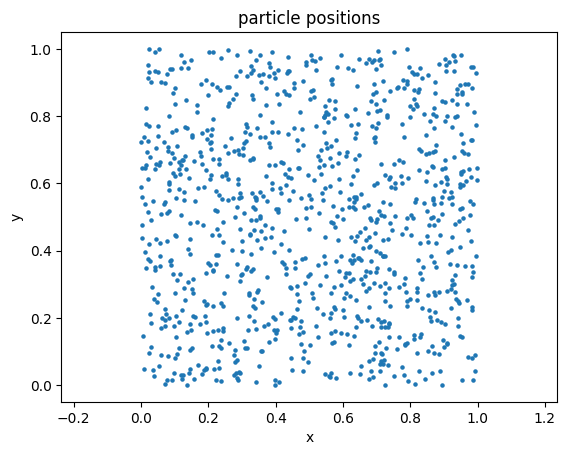

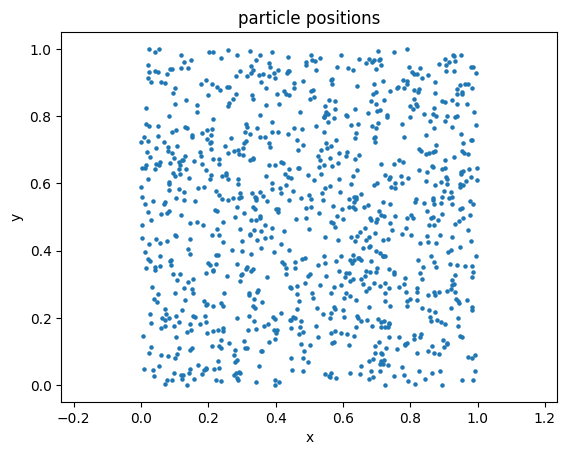

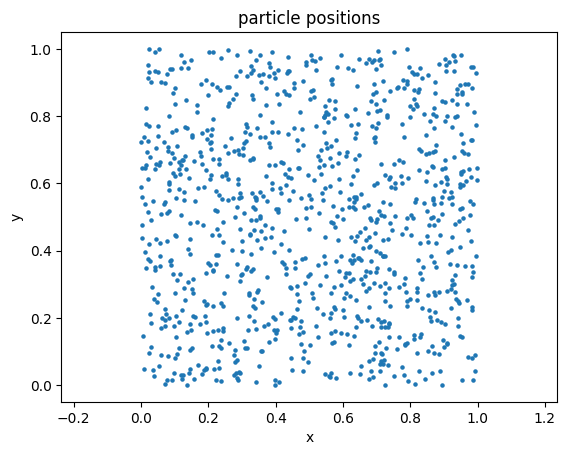

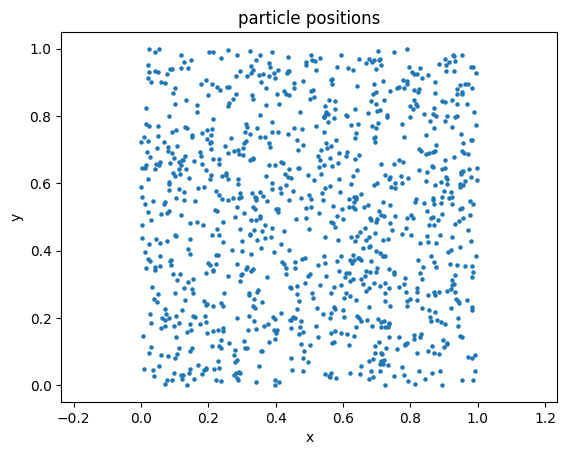

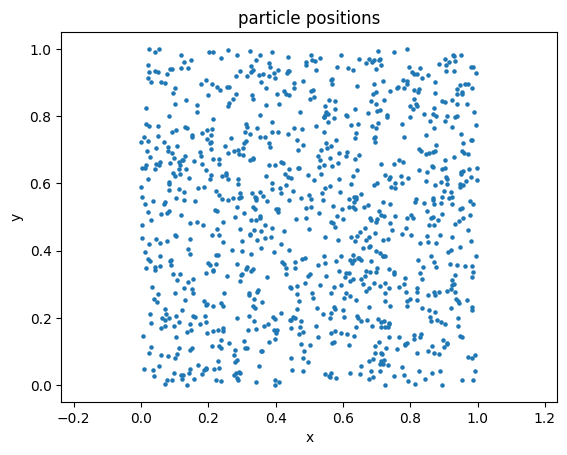

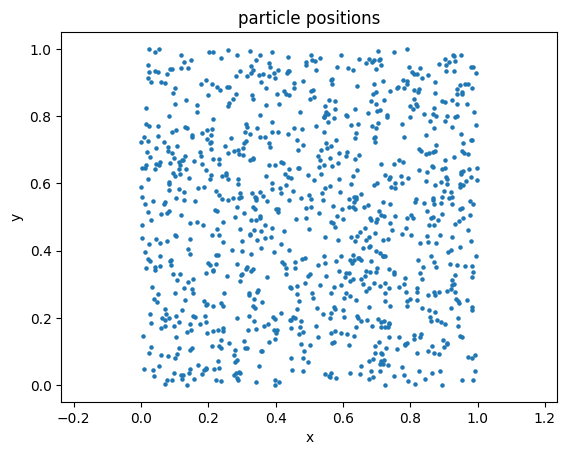

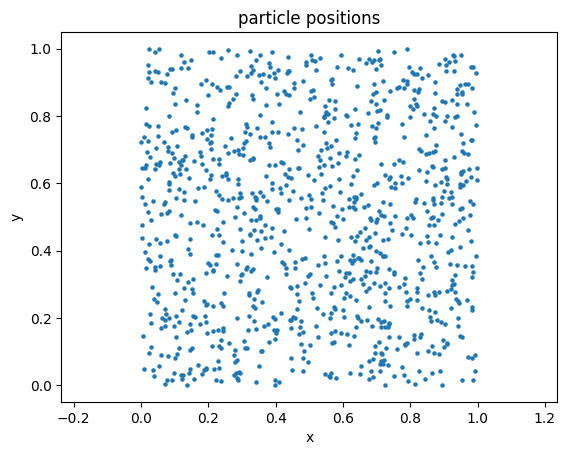

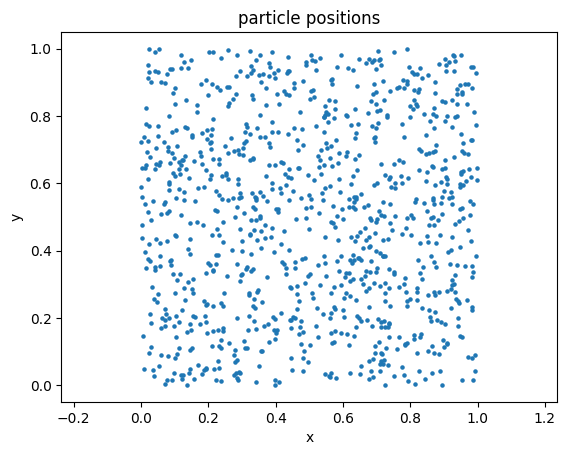

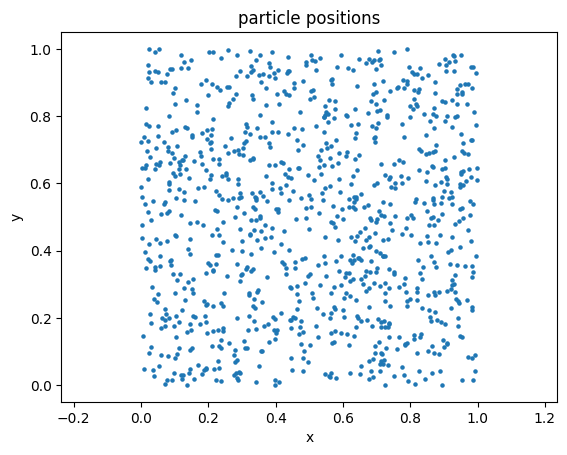

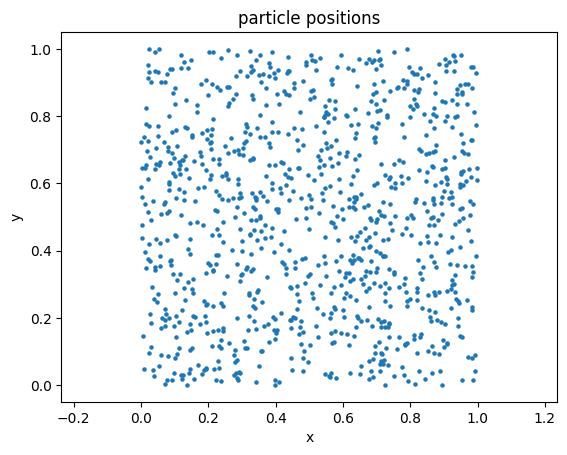

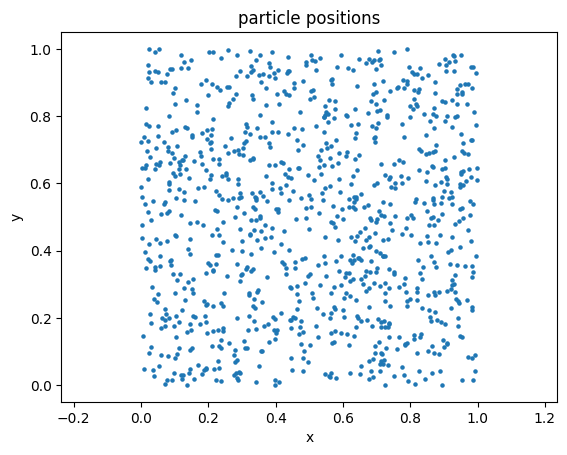

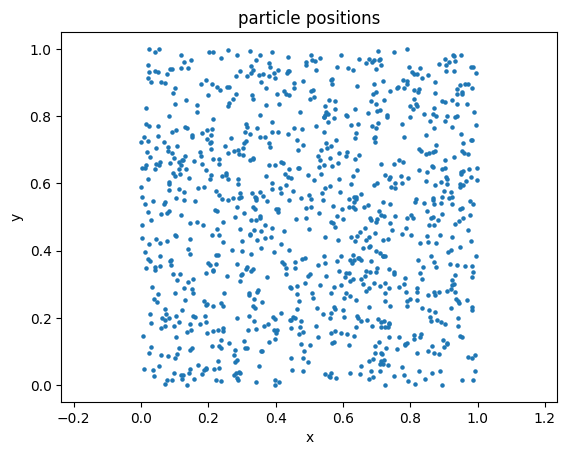

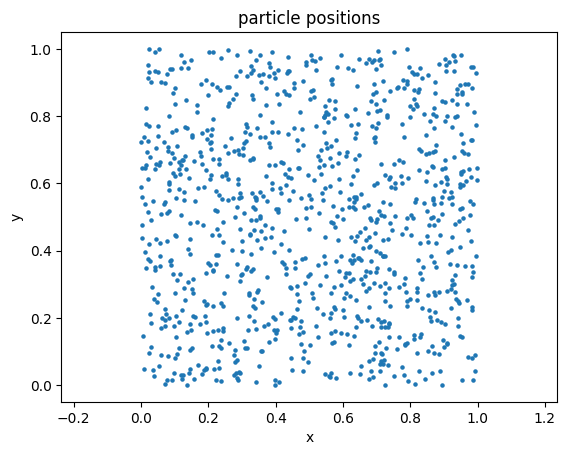

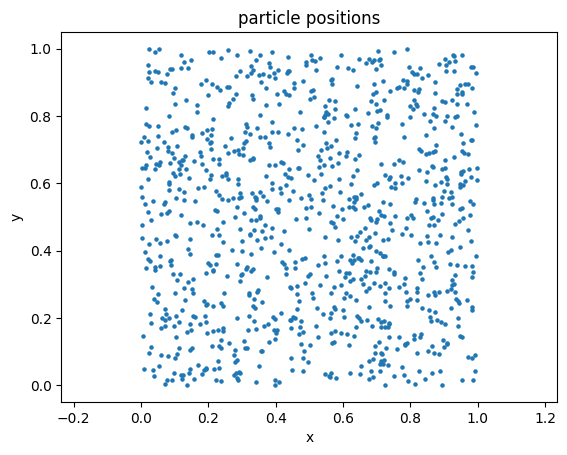

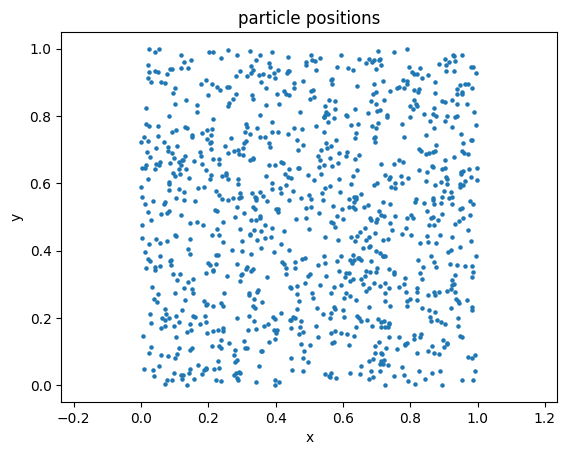

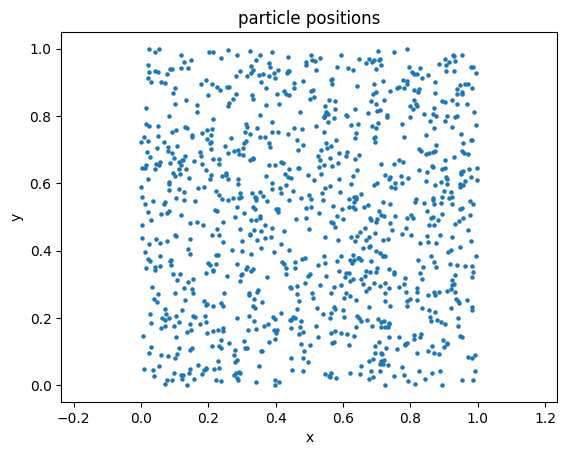

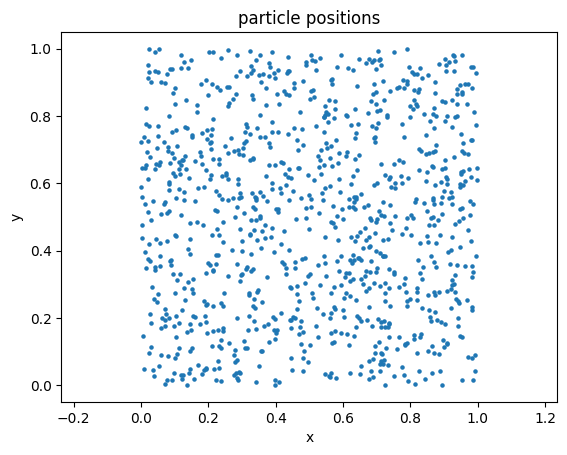

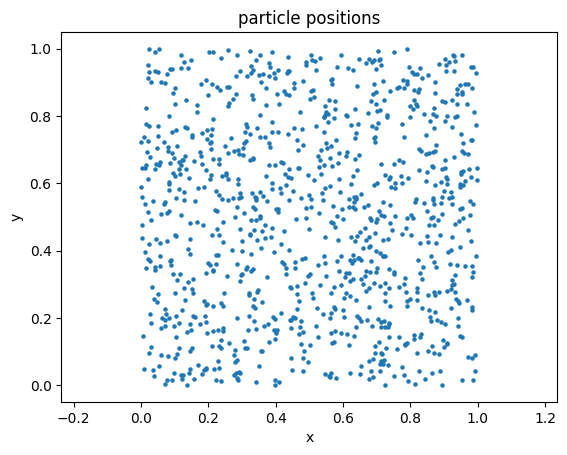

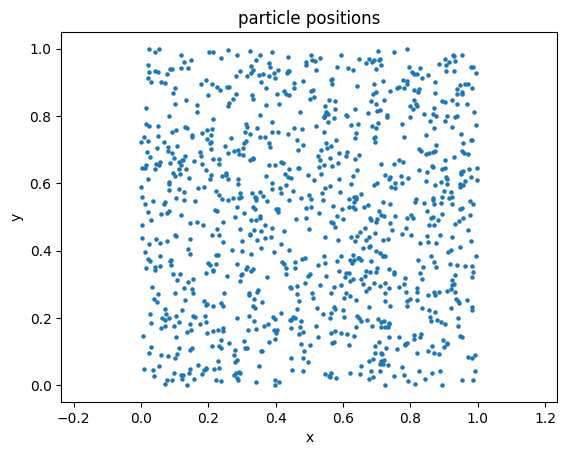

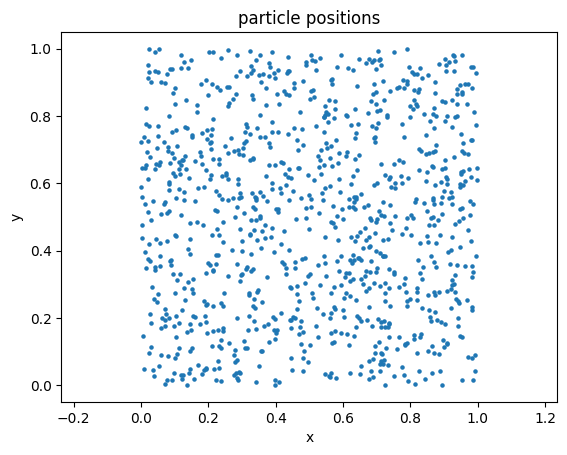

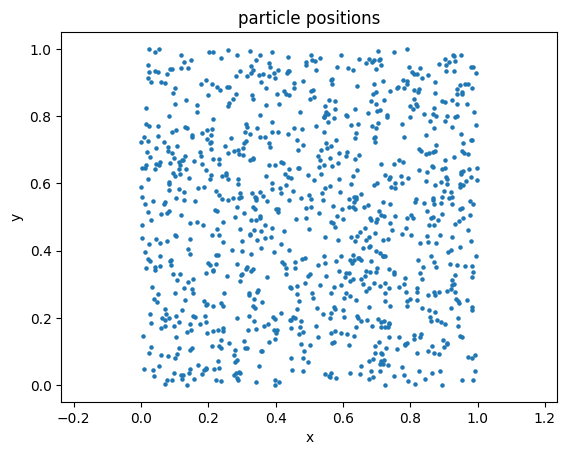

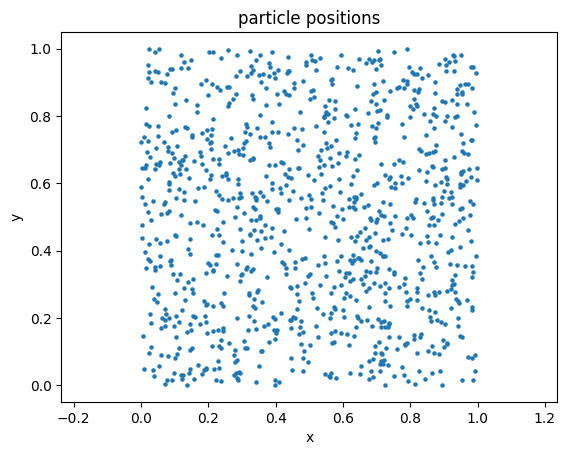

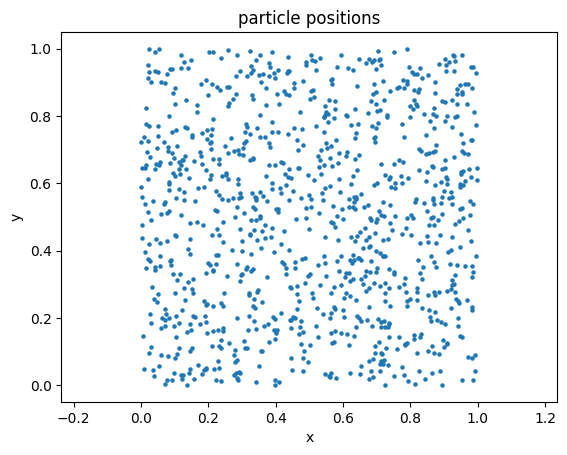

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import os

for file in os.listdir("/content/output"):
  if (file == None):
    continue
  df = pd.read_csv("/content/output/" + file)
  plt.scatter(df["x"], df["y"], s=5)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title("particle positions")
  plt.axis("equal") # same scale on both axes
  plt.show()
